# Generate single-cell images

Here, we are going to process the previously ingested microscopy images with the [scPortrait](https://github.com/MannLabs/scPortrait) pipeline to generate single-cell images that we can use to asses autophagosome formation at a single-cell level.

In [1]:
import lamindb as ln
import h5py

from typing import Iterable

from pathlib import Path
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
import spatialdata_plot
import h5py
import matplotlib.pyplot as plt
from spatialdata import to_polygons

ln.track()

→ connected lamindb: scportrait/examples


/Users/sophia/mambaforge/envs/lamin/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


→ there already is a notebook with `key` 'imaging2.ipynb', creating new version '9gzJFsXw1f6N0004'
→ created Transform('9gzJFsXw1f6N0004'), started new Run('5cHJDXir...') at 2025-03-03 13:56:41 UTC
→ notebook imports: h5py==3.13.0 lamindb==1.1.1 matplotlib==3.10.0 scportrait==1.1.1.dev0 spatialdata-plot==0.2.9 spatialdata==0.3.0


First, we query for the raw and annotated microscopy images.

In [21]:
input_images = (
    ln.Artifact.using("scportrait/examples").filter(ulabels__name="autophagy imaging")
    .filter(description__icontains="raw image")
    .filter(suffix=".tif")
)

The experiment contains different genotypes (`WT` and `EI24KO`) that were treated differently (`unstimulated` vs `14h Torin-1`).
For each condition multiple clonal cell lines and imaged multiple FOVs in all of the imaging channels are available.
To properly process this dataset we will need to get single-cell images from each FOV indivdually and tag them with all of the appropriate metadata so that we can identify genotype, treatment condition, clonal cell line and imaging experiment. 

In [3]:
conditions = [
    ln.ULabel.get(name=name)
    for name in set(af.features.get_values()["stimulation"] for af in input_images)
]
cell_line_clones = [
    ln.ULabel.get(name=name)
    for name in set(a.features.get_values()["cell_line_clone"] for a in input_images)
]
FOVs = [
    ln.ULabel.get(name=name)
    for name in set(a.features.get_values()["FOV"] for a in input_images)
]

In [4]:
input_images[0].features.get_values()

# would be nice to be able to do something equivalent to
# input_images.features.get_values()

{'FOV': 'FOV1',
 'artefact type': 'input images',
 'artifact type': 'input images',
 'cell_line_clone': 'U2OS lcklip-mNeon mCherryLC3B clone 1',
 'channel': 'Alexa488',
 'genotype': 'WT',
 'imaged structure': 'LckLip-mNeon',
 'magnification': '20X',
 'microscope': 'Opera Phenix',
 'stimulation': '14h Torin-1',
 'study': 'autophagy imaging',
 'resolution': 0.597976081}

In [5]:
# this is not working as expected -> should have a lot more features
ln.Artifact.filter(ulabels__name="autophagy imaging").df(features=True)

,uid,key,description,study,resolution,number of single-cells
id,,,,,,
310,dBMEVemoEUnmm9C40000,None,single-cell image dataset of cells stained for...,{autophagy imaging},{0.597976081},NaN
168,jEn1belfVUHZ2ki30000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},NaN
196,U2XUrYzh2XbSSDvr0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},NaN
307,63q4DugvGKRQgI1N0000,None,single-cell image dataset of cells stained for...,{autophagy imaging},{0.597976081},NaN
191,L27DL2LQhhhN4AwT0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},NaN
...,...,...,...,...,...,...
173,b8HyaXJMogUOo1Gd0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},NaN,NaN
188,S1vyYJFc9nAgOvRM0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},NaN,NaN
306,akvD6sPAMGVXBFh70000,None,single-cell image dataset of cells stained for...,{autophagy imaging},NaN,NaN


By iterating through conditions, celllines and FOVs, we should only have the images showing a single FOV in the 3 imaged channels.

In [6]:
number_of_channels = 3
for condition in conditions:
    for cellline in cell_line_clones:
        for FOV in FOVs:
            images = (
                input_images.filter(ulabels=condition)
                .filter(ulabels=cellline)
                .filter(ulabels=FOV)
                .distinct()
            )
            assert len(images) == number_of_channels

We  process these individual FOVs by ingesting our common config file and processing the images in scPortrait.

In [7]:
# load config file for processing all datasets
config_file_af = ln.Artifact.get(key="input_data_imaging_usecase/config.yml")
config_file_af.description = (
    "config for scportrait for processing of cells stained for autophagy markers"
)
config_file_af.save()

# annotate the config file with the metadata relevant to the study
config_file_af.features.add_values(
    {"study": "autophagy imaging", "artifact type": "scportrait config"}
)

Lets take a look at the processing of one example image.

In [ ]:
# get input images for one example FOV
condition = conditions[0]
cellline = cell_line_clones[0]
FOV = FOVs[0]

images = (
            input_images.filter(ulabels=condition)
            .filter(ulabels=cellline)
            .filter(ulabels=FOV)
            .distinct()
            )

# Perform quick sanity check that we only have images which share all of their attributed except channel and imaged structure
_features = []
values_to_ignore = ["channel", "imaged structure"]

for af in images:
    features = af.features.get_values()
    features = {
        key: features[key] for key in features.keys() if key not in values_to_ignore
    }
    _features.append(features)
assert all([_features[0] == f for f in _features])
shared_features = _features[0]

# bring image paths into the correct order for processing
paths = [
        images.filter(ulabels__name=channel_name).one().cache()
        for channel_name in ["DAPI", "Alexa488", "mCherry"]
    ]


In [ ]:
# define and create an output location for the processed data
output_directory = "processed_data"
Path(output_directory).mkdir(parents=True, exist_ok=True)

# initialize our scportrait project with a unique ID
unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
        " ", "_"
    )

# create the project location
project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
Path(project_location).mkdir(parents=True, exist_ok=True)

# initialize the project
project = Project(
    project_location=project_location,
    config_path=config_file_af.cache(),
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    overwrite=True,
)

# load our input images
project.load_input_from_tif_files(
    paths, overwrite=True, channel_names=["DAPI", "Alexa488", "mCherry"]
)

# process the project
project.segment()
project.extract()

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         processed_data/U2OS_lcklip-mNeon_mCherryLC3B_EI24_KO_clone_1/14h_Torin-1/FOV2/scportrait_project/scportrai
         t.sdata                                                                                                   


Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


scPortrait has generated two different results for us. The first are segmentation masks showing nucleus and cytosol.

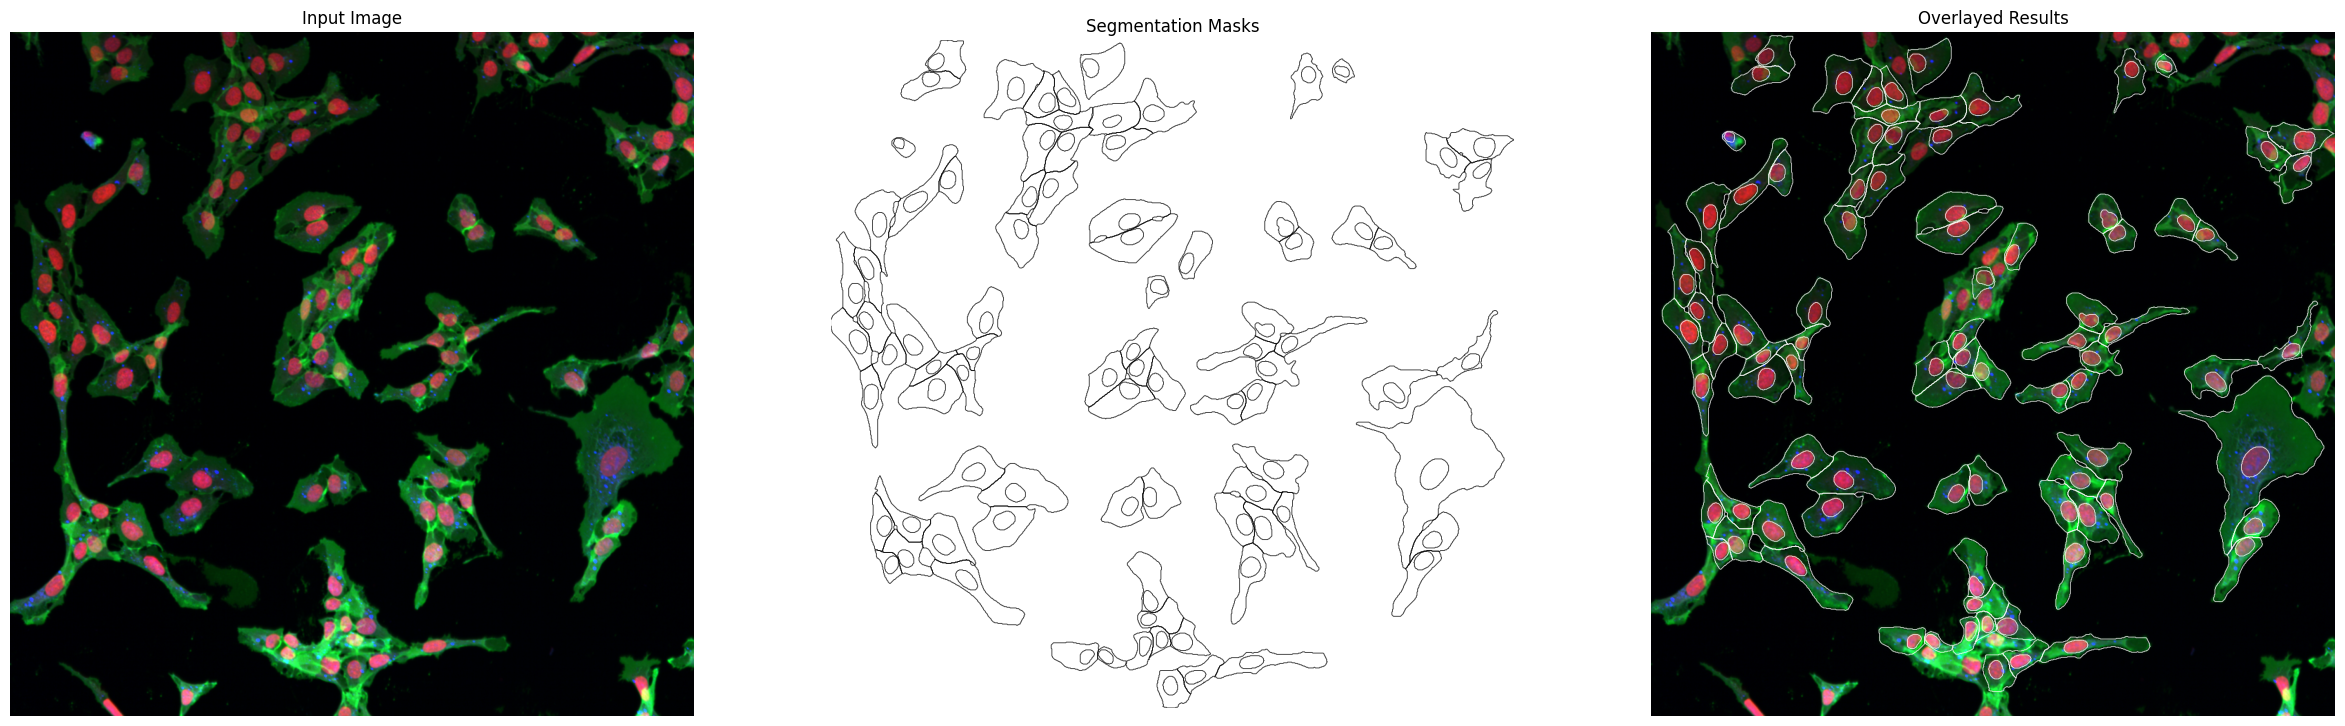

In [10]:
sdata = project.sdata

# convert rasterized segmentation results to a vectorized format for prettier visualization
sdata["seg_all_nucleus_vectorized"] = to_polygons(sdata["seg_all_nucleus"])
sdata["seg_all_cytosol_vectorized"] = to_polygons(sdata["seg_all_cytosol"])

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sdata.pl.render_images("input_image").pl.show(ax=axs[0], title="Input Image");
sdata.pl.render_shapes("seg_all_nucleus_vectorized", fill_alpha=0, outline_alpha=0.7, outline_width=0.7, outline_color = "black").pl.show(ax=axs[1], title="Segmentation Masks");
sdata.pl.render_shapes("seg_all_cytosol_vectorized", fill_alpha=0, outline_alpha=0.7, outline_width=0.7, outline_color = "black").pl.show(ax=axs[1], title="Segmentation Masks");

sdata.pl.render_images("input_image").pl.show(ax=axs[2], title="Input Image");
sdata.pl.render_shapes("seg_all_nucleus_vectorized", fill_alpha=0, outline_alpha=0.7, outline_width=0.7, outline_color = "white").pl.show(ax=axs[2], title="Segmentation Masks");
sdata.pl.render_shapes("seg_all_cytosol_vectorized", fill_alpha=0, outline_alpha=0.7, outline_width=0.7, outline_color = "white").pl.show(ax=axs[2], title="Overlayed Results");

axs[0].axis("off");
axs[1].axis("off");
axs[2].axis("off");

In addition we now also have a complete single-cell image dataset, were we have both the Mask Information as well as the pixel information for each imaged channel.

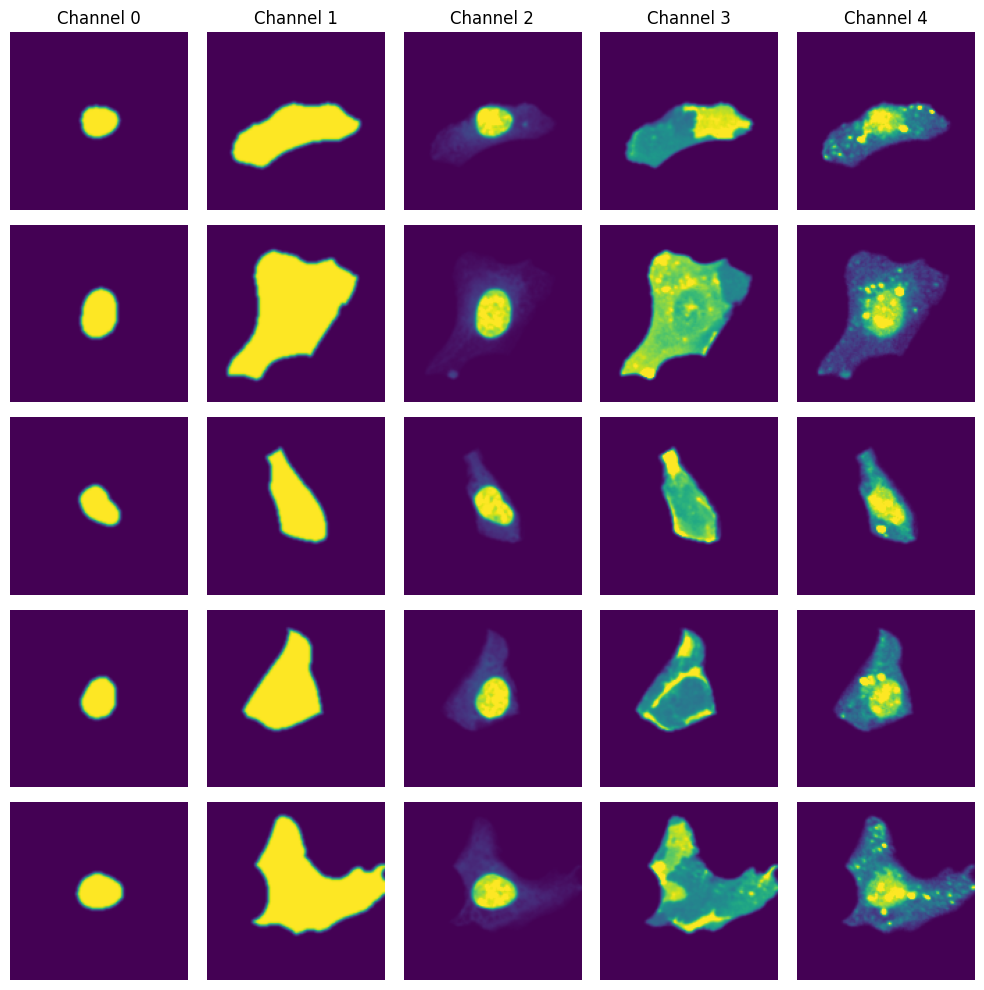

In [11]:
single_cell_data = project.extraction_f.output_path
n_cells = 5

with h5py.File(single_cell_data, "r") as f:
    images = f['single_cell_data'][0:n_cells]

n_channels = 5
fig, axs = plt.subplots(n_channels, n_cells, figsize=(2 * n_channels, 2 * n_cells))

for i in range(n_cells):
    for j in range(n_channels):
        axs[i, j].imshow(images[i][j], vmin = 0, vmax = 1)
        axs[i, j].axis("off")

        if i == 0:
            axs[i, j].set_title(f"Channel {j}")

fig.tight_layout()


Now we also want to save these results to our instance. 

In [12]:
# # upload the segmentation results saved as a spatialdata object
# sdata = project.filehandler.get_sdata()

# #update annotation with shared features
# annotation = shared_features.copy()
# annotation["filetype"] = "spatialdata"
# sdata.attrs["sample"] = annotation

# curator = ln.Curator.from_spatialdata(
#     sdata,
# )

# curator.save_artifact(description = "scportrait spatialdata object containing results of cells stained for autophagy markers")

In [13]:
# upload the single-cell image datasets saved as a .h5 file
annotation = shared_features.copy()
annotation["filetype"] = "h5"  # update filetype to h5
annotation["number of single-cells"] = h5py.File(single_cell_data, "r")[
    "single_cell_index"
].shape[0]

annotation["channel"] = [
    ln.ULabel.get(name=channel_name)
    for channel_name in ["DAPI", "mCherry", "Alexa488"]
]
annotation["imaged structure"] = [
    ln.ULabel.get(name=structure_name)
    for structure_name in ["LckLip-mNeon", "DNA", "mCherry-LC3B"]
]

artifact = ln.Artifact(
    single_cell_data,
    description="single-cell image dataset of cells stained for autophagy markers",
)
artifact.save()
artifact.features.add_values(annotation)
artifact.labels.add(ln.ULabel.get(name="scportrait single-cell images"))

→ found artifact with same hash: Artifact(uid='jFAfAeaMt3rHfNpl0000', is_latest=True, description='single-cell image dataset of cells stained for autophagy markers', suffix='.h5', size=2320453, hash='sME-iwAeTK9HTJFHGHX1NQ', space_id=1, storage_id=1, run_id=170, created_by_id=4, created_at=2025-03-03 13:49:22 UTC); to track this artifact as an input, use: ln.Artifact.get()


To make our lives easier so that we can process all of the files in our dataset we are going to write a custom image processing function.
We decorate this function with :func:`~lamindb.tracked` to track data lineage of the input and output Artifacts. To improve processing time we will only recompute datasets that have not been previously processed and uploaded to our instance.

In [ ]:
@ln.tracked()
def _process_images(
    config_file_af: ln.Artifact,
    input_artifacts: Iterable[ln.Artifact],
    output_directory: str,
) -> None:

    # Perform quick sanity check that we only have images which share all of their attributed except channel and imaged structure
    _features = []
    values_to_ignore = ["channel", "imaged structure"]

    for af in input_artifacts:
        features = af.features.get_values()
        features = {
            key: features[key] for key in features.keys() if key not in values_to_ignore
        }
        _features.append(features)
    assert all([_features[0] == f for f in _features])
    shared_features = _features[0]

    # check if processed results already exist and if so skip processing
    try:
        # check for single-cell images
        (ln.Artifact.using("scportrait/examples").filter(ulabels__name="scportrait single-cell images")
        .filter(ulabels__name=shared_features["cell_line_clone"])
        .filter(ulabels__name=shared_features["stimulation"])
        .filter(ulabels__name=shared_features["FOV"])
        .distinct().one()
        )

        # check for spatialdata object
        ### NEEDS TO BE ADDED HERE
        print("Dataset already processed and results uploaded to instance. Skipping processing.")
    except:
        # get the paths to the input images
        paths = [
            input_artifacts.filter(ulabels__name=channel_name).one().cache()
            for channel_name in ["DAPI", "Alexa488", "mCherry"]
        ]

        # create a unique identifier for the project based on the annotated features
        unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
            " ", "_"
        )

        # create the project location
        project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
        Path(project_location).mkdir(parents=True, exist_ok=True)

        project = Project(
            project_location=project_location,
            config_path=config_file_af.cache(),
            segmentation_f=CytosolSegmentationCellpose,
            extraction_f=HDF5CellExtraction,
            overwrite=True,
        )

        # process the project
        project.load_input_from_tif_files(
            paths, overwrite=True, channel_names=["DAPI", "Alexa488", "mCherry"]
        )
        project.segment()
        project.extract()

        # update the annotation to reflect the new data modality
        single_cell_images = f"{project_location}/extraction/data/single_cells.h5"
        annotation = shared_features
        annotation["filetype"] = "h5"  # update filetype to h5
        annotation["number of single-cells"] = h5py.File(single_cell_images, "r")[
            "single_cell_index"
        ].shape[0]
        annotation["channel"] = [
            ln.ULabel.get(name=channel_name)
            for channel_name in ["DAPI", "mCherry", "Alexa488"]
        ]
        annotation["imaged structure"] = [
            ln.ULabel.get(name=structure_name)
            for structure_name in ["LckLip-mNeon", "DNA", "mCherry-LC3B"]
        ]

        artifact = ln.Artifact(
            single_cell_images,
            description="single-cell image dataset of cells stained for autophagy markers",
        )
        artifact.save()
        artifact.features.add_values(annotation)
        artifact.labels.add(ln.ULabel.get(name="scportrait single-cell images"))


ln.Param(name="output_directory", dtype="str").save()

→ returning existing Param record with same name: 'output_directory'


Param(name='output_directory', dtype='str', is_type=False, created_by_id=4, run_id=28, space_id=1, created_at=2025-02-05 14:37:33 UTC)

Now we are ready to process all of our input images and upload the generated single-cell image datasets back to lamin.

In [15]:
for condition in conditions:
    for cellline in cell_line_clones:
        for FOV in FOVs:
            images = (
                input_images.filter(ulabels=condition)
                .filter(ulabels=cellline)
                .filter(ulabels=FOV)
                .distinct()
            )
            _process_images(
                config_file_af,
                input_artifacts=images,
                output_directory=output_directory,
            )

! cannot infer feature type of: <QuerySet [Artifact(uid='DtiDYScl1dL1zcqs0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_Alexa488_zstack001_r001_c008.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='WyabAqK4jeZtTtrQ9rvUeQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:33 UTC), Artifact(uid='9ImieKkFxhw9F63L0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_DAPI_zstack001_r001_c008.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='eXaBPwLJJ--9SyGD7JR0ew', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:36 UTC), Artifact(uid='FjsCGq8IK1BouyZc0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_mCherry_zstack001_r001_c008.tif', description='raw image of U2OS cells stained for autophagy ma

! The following artifacts are both inputs and outputs of Run(uid=u6S41BHOmt5H3qkRcAYj): {Artifact(uid='Oxa5oKf4zUU6NDQw0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_Alexa488_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='5cfc02GejBaoJ0h3OLWSdw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:22 UTC), Artifact(uid='7nle3IqVf76F1xp90000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_DAPI_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='CmAa139DH_lQ2Plcy4BxXw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:26 UTC), Artifact(uid='OKdwPqnoJ1blWYFQ0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_mCherry_zstack001_r002_c009.tif', description='ra

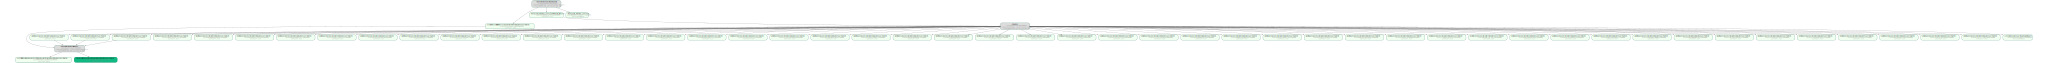

In [16]:
example_artifact = ln.Artifact.filter(
    ulabels=ln.ULabel.get(name="scportrait single-cell images")
)[0]
example_artifact.view_lineage()

In [17]:
ln.finish()

• please hit CMD + s to save the notebook in your editor ... ✓
→ finished Run('5cHJDXir') after 5m at 2025-03-03 14:01:46 UTC
→ go to: https://lamin.ai/scportrait/examples/transform/9gzJFsXw1f6N0004
→ to update your notebook from the CLI, run: lamin save /Users/sophia/Documents/GitHub/lamin-usecases/docs/imaging2.ipynb


In [18]:
ln.Artifact.using("scportrait/examples").filter(ulabels__name="scportrait single-cell images").df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
303,UazRFK4XOESvHnv10000,None,single-cell image dataset of cells stained for...,.h5,None,None,2088813,ojzlPAA_ONvKtiTER7fsCg,None,None,md5,True,False,1,1,None,None,True,164,2025-03-03 13:37:57.860564+00:00,4,None,1
304,jFAfAeaMt3rHfNpl0000,None,single-cell image dataset of cells stained for...,.h5,None,None,2320453,sME-iwAeTK9HTJFHGHX1NQ,None,None,md5,True,False,1,1,None,None,True,185,2025-03-03 13:49:22.957168+00:00,4,None,1
305,Cm5WxROsxeewIeLj0000,None,single-cell image dataset of cells stained for...,.h5,None,None,1021389,N-jG3trhws9W_QYr8293sA,None,None,md5,True,False,1,1,None,None,True,171,2025-03-03 13:49:45.777282+00:00,4,None,1
306,akvD6sPAMGVXBFh70000,None,single-cell image dataset of cells stained for...,.h5,None,None,1260871,jPMxOvn535yuxAHxbAQKNQ,None,None,md5,True,False,1,1,None,None,True,172,2025-03-03 13:50:07.195831+00:00,4,None,1
307,63q4DugvGKRQgI1N0000,None,single-cell image dataset of cells stained for...,.h5,None,None,1877193,1SSxNTO6lnwh3H5x2c164A,None,None,md5,True,False,1,1,None,None,True,173,2025-03-03 13:50:27.312553+00:00,4,None,1
308,7rTkvhFaU91Mj6E00000,None,single-cell image dataset of cells stained for...,.h5,None,None,1180780,EuNSRhXJdXYjRMnoC7hMzQ,None,None,md5,True,False,1,1,None,None,True,174,2025-03-03 13:50:50.140906+00:00,4,None,1
309,VdTjZYc2kGMb41vO0000,None,single-cell image dataset of cells stained for...,.h5,None,None,2442421,utiA6tVKQcQO9dv88CLAmw,None,None,md5,True,False,1,1,None,None,True,175,2025-03-03 13:51:13.389377+00:00,4,None,1
310,dBMEVemoEUnmm9C40000,None,single-cell image dataset of cells stained for...,.h5,None,None,3713581,BAS10Jd1pbtl0FBnOr2ILg,None,None,md5,True,False,1,1,None,None,True,176,2025-03-03 13:51:38.479178+00:00,4,None,1
311,2djZ27LnCjxP9oIS0000,None,single-cell image dataset of cells stained for...,.h5,None,None,4315062,HbAmk6hwFMX2smLpb34XwQ,None,None,md5,True,False,1,1,None,None,True,177,2025-03-03 13:52:08.154841+00:00,4,None,1
